EOF
Execution time: 126.537 seconds.
Top-1024 in CMS-8*5500
Precision:  0.892
Top_dict with 129400 bytes.
Sketch with 176576 bytes.
Total size 298.8046875 bytes, 
Find:913
Top_ARE: 1.5574
Top_AAE: 106.9277
Estimate time:  0.743 seconds.


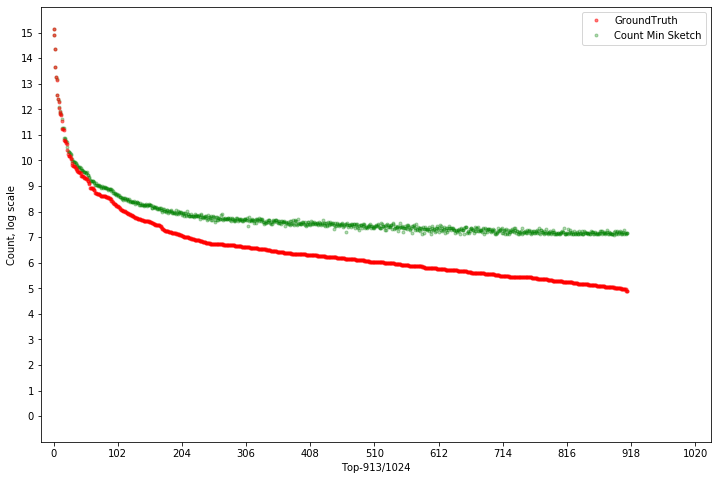

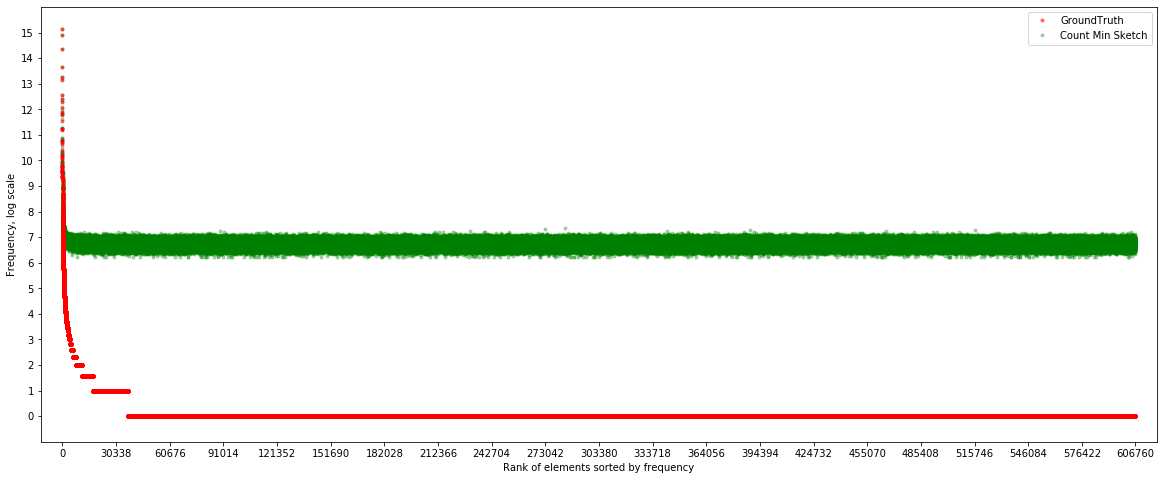

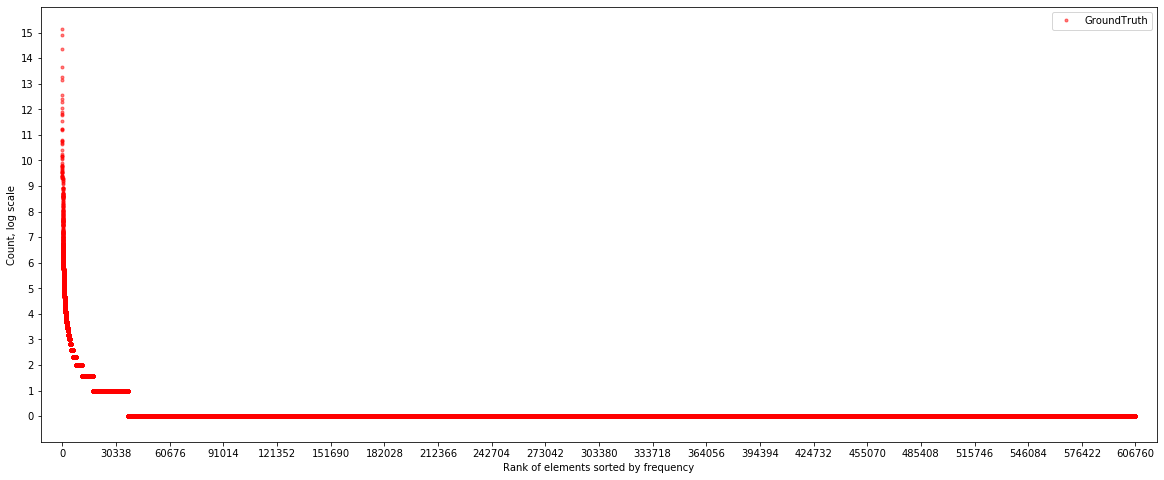

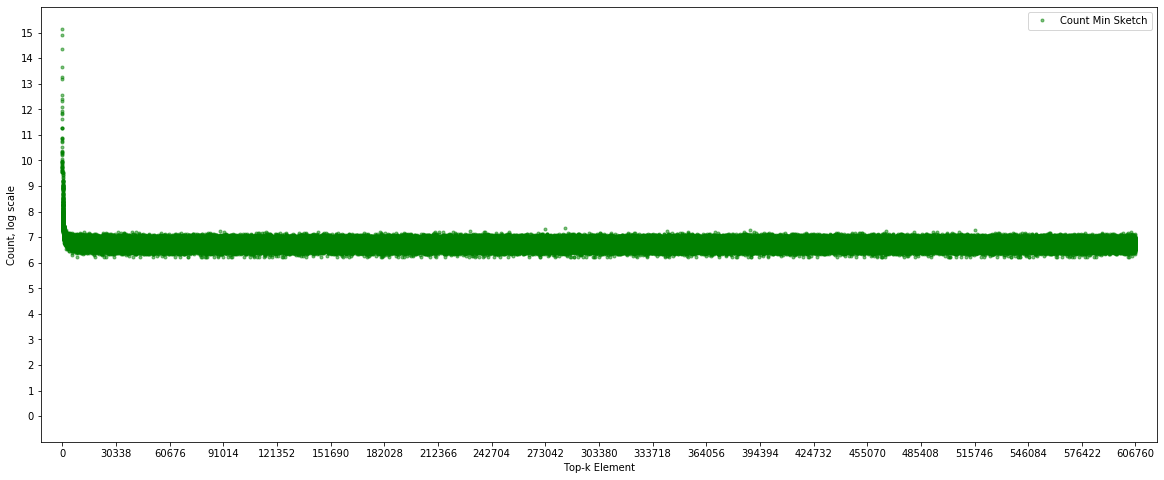

In [1]:
# kosarak
# track Top-k element all the time
import sys
sys.path.append("..")
from cms.CountMinSketch import CountMinSketch
import Tools.Config as TC
import Tools.Func as TF
import Node.DS as DS

import time
import os
from pympler import asizeof

# =============================dataset path and file=============================
filename='kosarak.dat'
filepath=r"..\..\dataset\kosarak"
gr_file_name='kosarak_ground_truth.csv'
src_data=os.path.join(filepath,filename)
    # dataset
gr_path=os.path.join(filepath,gr_file_name)
    # ground truth

# =============================Initialize=============================
w=5500
d=8
size=1024
topk=1024
TC.Set_default(w,d,size,topk)
cms=CountMinSketch(TC.width,TC.depth)
Top_dict=dict()

# =============================Stream processing=============================
#item_count=10000
start=time.time()
with open(src_data,'r') as file:
    while True:
        e=file.readline().strip('\n')
        if not e:
            print('EOF')
            break
        else:
            #item_count-=1
            item=DS.Tail(e,1)
            cms.Add_CMS(item)
            count=cms.Estimate_CMS(item)
            if len(Top_dict)<TC.size:
                Top_dict[item.ID]=count
            else:
                if Top_dict.get(item.ID):
                    # e in Top
                    Top_dict[item.ID]=count
                else:
                    min_ele = min(Top_dict, key=Top_dict.get)
                        # find e_min
                    if count >Top_dict[min_ele]:
                        Top_dict[item.ID]=count
                        Top_dict.pop(min_ele)

end=time.time()

# =============================Print and Plot result=============================
Top_dict=dict(sorted(Top_dict.items(), key=lambda item: item[1],reverse=True))
print("Execution time:{:8.3f} seconds.".format(end-start))

# Element-Precision
tp_set,precision=TF.Get_precision(gr_path,Top_dict,TC.topk)
print("Top-{} in CMS-{}*{}".format(TC.topk,TC.depth,TC.width))
print("Precision: {:6.3f}".format(precision))

# Count-Precision


# Memory usage
sk0=asizeof.asizeof(Top_dict)
sk1=asizeof.asizeof(cms)
print("Top_dict with {} bytes.".format(sk0))
print("Sketch with {} bytes.".format(sk1))
print("Total size {} bytes, ".format((sk0+sk1)/1024))


# Count ARE/AAE in Top
startx=time.time()
top_are,top_aae=TF.Get_ARE_AAE(gr_path,Top_dict,tp_set)
print("Find:{}".format(len(tp_set)))
#print("{} item found in SS[{}] compare with true Top-{}".format(len(tp_set),Config.size,topk))
endx=time.time()

print("Top_ARE: {:6.4f}".format(top_are))
print("Top_AAE: {:6.4f}".format(top_aae))
print("Estimate time:{:7.3f} seconds.".format(endx-startx)) 

TF.Plot_topk_compare(gr_path,Top_dict,"Count Min Sketch")

# All element compare
ground_truth=TF.Get_ground_truth(gr_path)
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=cms.Estimate_CMS(DS.Tail(item,1))
TF.Plot_all_compare(ground_truth,My_result,"Count Min Sketch")

In [8]:
# entropy
import math
total_count=990002
H_t=0
H_c=0
ground_truth=TF.Get_ground_truth(gr_path)
# ground_truth: dict
My_result=dict()
for item in ground_truth:
    # item:ID of e
    My_result[item]=cms.Estimate_CMS(DS.Tail(item,1))
    H_t+=(abs(ground_truth[item])/total_count)*(math.log2(total_count/abs(ground_truth[item])))
    H_c+=(abs(cms.Estimate_CMS(DS.Tail(item,1)))/total_count)*(math.log2(total_count/abs(cms.Estimate_CMS(DS.Tail(item,1)))))
print(H_t)
print(H_c)

16.368266611528576
881.6440159722086
